# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

## Dữ liệu

In [2]:
# RICE_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua.csv"

In [3]:
df_rice = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe.csv', encoding='ISO-8859-1')

In [4]:
df_rice.head()

,date,price
0,1/2/2007,21600.0
1,1/3/2007,22000.0
2,1/4/2007,21700.0
3,1/5/2007,22000.0
4,1/6/2007,22000.0


### EDA data

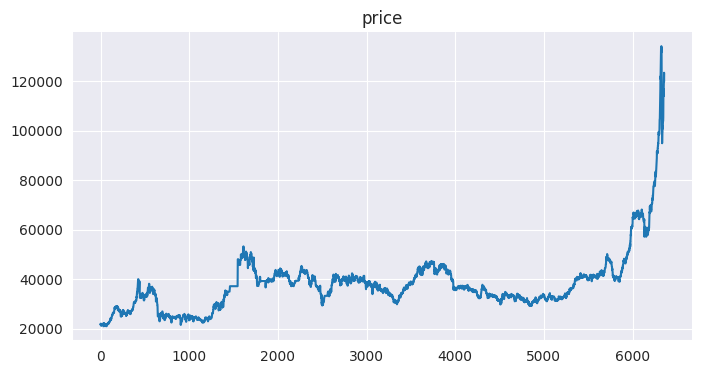

In [5]:
from matplotlib import pyplot as plt
df_rice['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
df_rice.set_index('date', inplace=True)

In [7]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6358 entries, 1/2/2007 to 6/1/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6358 non-null   float64
dtypes: float64(1)
memory usage: 99.3+ KB


### Xử lí outlier

<Axes: >

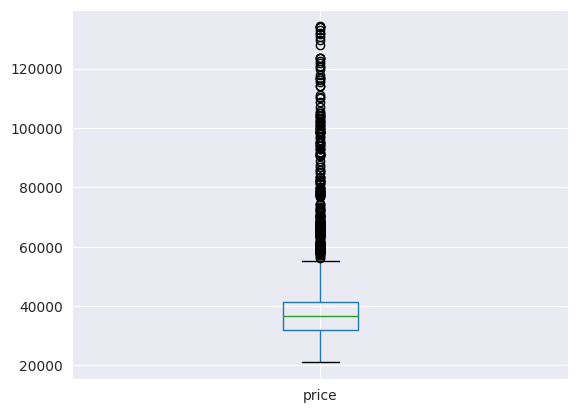

In [8]:
df_rice.boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_rice['price'].quantile(0.25)
Q3 = df_rice['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_rice[(df_rice['price'] < lower_bound) | (df_rice['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_rice.at[df_rice.index[0], 'price'] = min(max(df_rice.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_rice.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_rice.index[previous_date_index]
        previous_value = df_rice.loc[previous_date, 'price']
        df_rice.at[index, 'price'] = previous_value

Số lượng outlier: 380


<Axes: >

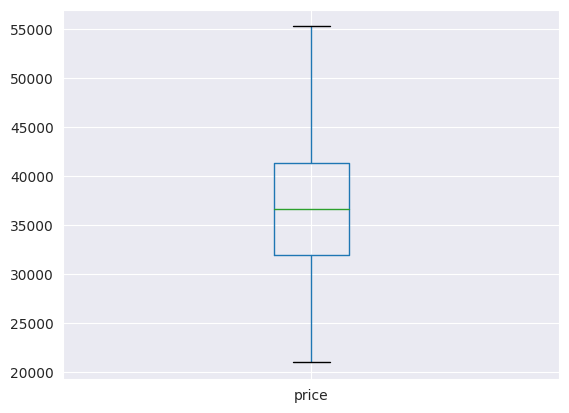

In [10]:
df_rice.boxplot()

<Axes: xlabel='date'>

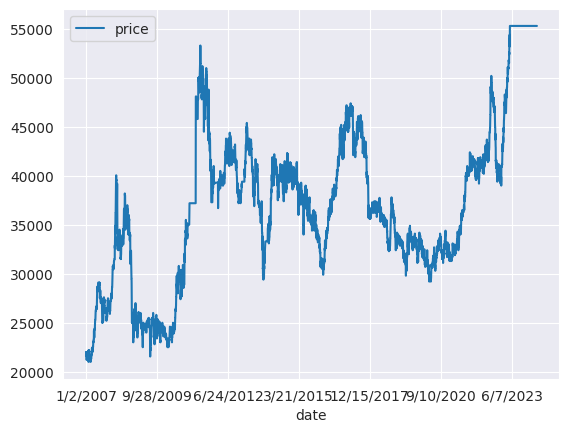

In [11]:
df_rice.plot()

### Smothing Data

Moving average smoothing: Giá trị tại một điểm dữ liệu sẽ được tính bằng trung bình k giá trị phía trước. 
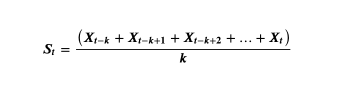

In [12]:
df_rice = df_rice.rolling(45).mean()
df_rice = df_rice.dropna()

<Axes: xlabel='date'>

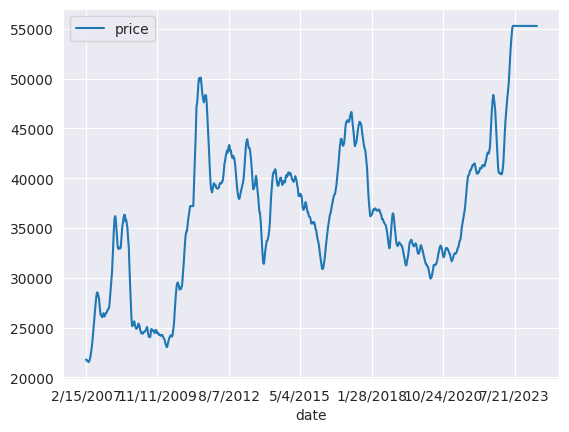

In [13]:
df_rice.plot()

# Kiểm tra tính dừng

In [14]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=1).mean()
    movingSTD = timeseries.rolling(window=1).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

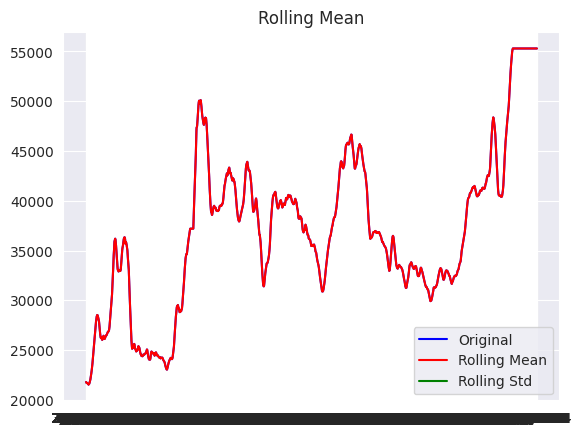

Results of Dickey Fuller Test:
Test Statistic                   -2.600732
p-value                           0.092846
#Lags Used                        9.000000
Number of Observations Used    6304.000000
Critical Value (1%)              -3.431388
Critical Value (5%)              -2.861999
Critical Value (10%)             -2.567014
dtype: float64


In [15]:
test_stationarity(df_rice.price)

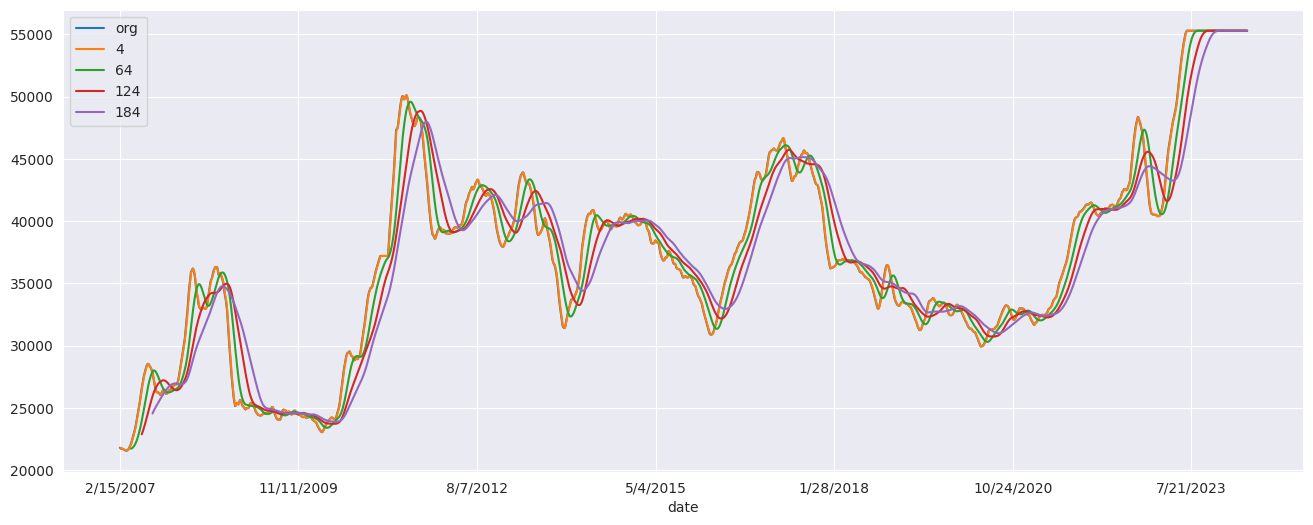

In [16]:
plt.figure(figsize=(16,6))
df_rice.price.plot(label="org")
for i in range(4,200,60):
    df_rice["price"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

In [18]:
from statsmodels.tsa.stattools import pacf
pacf(df_rice.price, nlags=10)

array([ 1.        ,  0.99941107, -0.04668272, -0.04392722, -0.04094417,
       -0.03857133, -0.03618166, -0.03399103, -0.03172949, -0.02983407,
       -0.02781801])

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.acf(df_rice.price, nlags=10)
    plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [21]:
df1 = df_rice.price.copy()

### Stationary Data

Tiếp theo, chúng tôi kiểm tra tính dừng (stationarity), lấy sai phân (differencing) cho dữ liệu bằng các phương pháp như Random Walk Model, Second-Order Differencing, Seasonal Differencing, Augmented Dickey-Fuller. Phân rã chuỗi thời gian thành các thành phần (decomposition) mang tính xu hướng, mùa vụ hoặc chu kỳ. 

In [22]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

In [23]:
# invert differenced forecast
def inverse_difference(last_ob, value):
  return value + last_ob

In [24]:
diff = difference(df1, 60)

In [25]:
from matplotlib import pyplot

In [26]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00


In [27]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6314 entries, 2/15/2007 to 6/1/2024
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6314 non-null   float64
dtypes: float64(1)
memory usage: 98.7+ KB


In [28]:
df1 = df1.copy()

In [29]:
# df1['price'] = df_rice["price"].rolling(60).mean()

In [30]:
df1

date
2/15/2007    21793.333333
2/16/2007    21786.666667
2/17/2007    21771.111111
2/18/2007    21762.222222
2/19/2007    21746.666667
                 ...     
5/28/2024    55300.000000
5/29/2024    55300.000000
5/30/2024    55300.000000
5/31/2024    55300.000000
6/1/2024     55300.000000
Name: price, Length: 6314, dtype: float64

In [31]:
df1 = df1.dropna()


In [32]:
df1.info()

<class 'pandas.core.series.Series'>
Index: 6314 entries, 2/15/2007 to 6/1/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
6314 non-null   float64
dtypes: float64(1)
memory usage: 98.7+ KB


### Phân chia dữ liệu

In [33]:
size = int(len(df1) * 0.8)
train_data = df1[:size]
test_data = df1[size:]

<Axes: xlabel='date'>

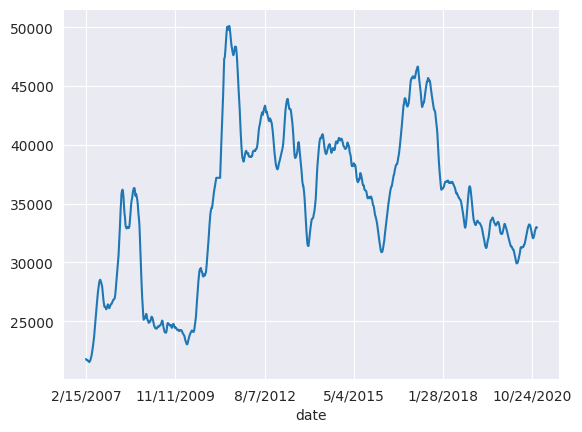

In [34]:
train_data.plot()

In [35]:
train_data =  train_data.diff()

In [36]:
train_data.info()
train_data = train_data.dropna()

<class 'pandas.core.series.Series'>
Index: 5051 entries, 2/15/2007 to 12/13/2020
Series name: price
Non-Null Count  Dtype  
--------------  -----  
5050 non-null   float64
dtypes: float64(1)
memory usage: 78.9+ KB


<Axes: xlabel='date'>

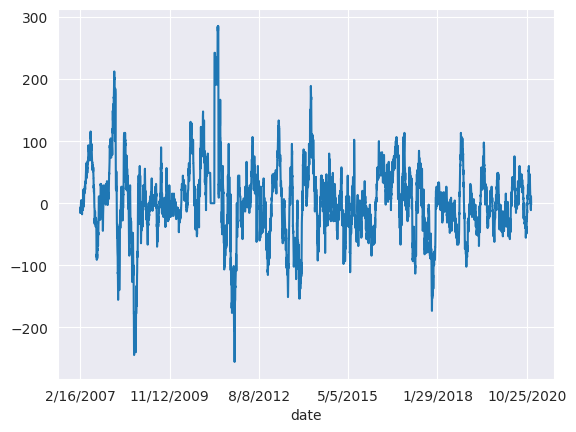

In [37]:
train_data.plot()

Kiểm tra dữ liệu ở tập train đã dừng phù hợp cho các mô hình

In [38]:
adf_test(train_data)

Reject the null hypothesis
Data is stationary


In [39]:
diff_data = train_data.copy()
diff_data.iloc[0] = train_data.iloc[0]

# Compute the cumulative sum to revert the diff transformation
reverted_data = diff_data.cumsum()

<Axes: xlabel='date'>

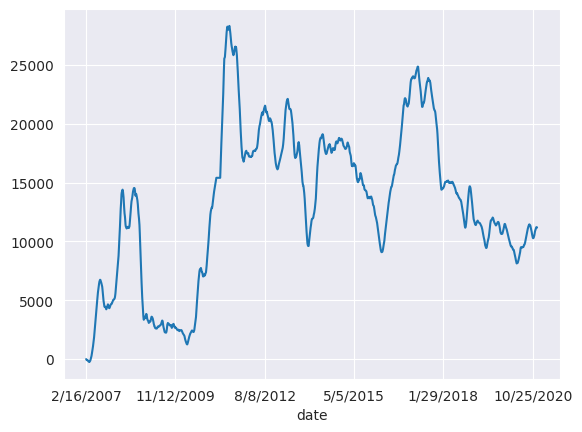

In [40]:
reverted_data.plot()

In [41]:
size

5051

In [42]:
train_data.values

array([ -6.66666667, -15.55555556,  -8.88888889, ...,  11.11111111,
        -2.22222222,  -2.22222222])

## ARIMA MODEL

Chúng tôi sử dụng phương pháp điều chỉnh tham số bằng cách lặp qua các bộ tham số tương tứng (p, d, q) cho ARIMA, kết hợp biến ngoại sinh (exogenous) cho mô hình ARIMAX, (p) cho mô hình VAR và (p, q) cho mô hình VARMA.  

Chọn tham số (p, q) cho mô hình VARMA còn là sự kết hợp với mô hình ARIMA để tìm được bộ tham số tốt nhất cho tập dữ liệu giá. Sau đó áp dụng vào mô hình với dữ liệu đa biến để tăng tốc độ và đảm bảo mô hình có độ chính xác cao.  

Việc chọn tham số cần kết hợp với các đồ thị tự tương quan ACF và PACF để chọn đầu vào tối ưu. 

In [43]:
import pmdarima as pm

model_arima = pm.auto_arima(train_data.values, start_p=3, start_q=3,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=40741.939, Time=5.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55598.231, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40745.327, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=50134.167, Time=1.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=40740.238, Time=3.00 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=40738.245, Time=2.90 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=45207.575, Time=7.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=40744.461, Time=1.24 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=40740.231, Time=1.88 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=46996.669, Time=5.00 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=43955.262, Time=8.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=40741.999, Time=7.89 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=40742.190, Time=2.93 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=40740.155, Time=2.06 sec

Best model:  ARIMA

Kiểm tra kết quả

In [44]:
n_periods = len(test_data)
fc, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True, dynamic=True)
index_of_fc = np.arange(len(test_data), len(test_data.values) + n_periods)

In [45]:
fc_series = pd.Series(np.square(fc), index=test_data.index)

In [46]:
test_data.info()

<class 'pandas.core.series.Series'>
Index: 1263 entries, 12/14/2020 to 6/1/2024
Series name: price
Non-Null Count  Dtype  
--------------  -----  
1263 non-null   float64
dtypes: float64(1)
memory usage: 19.7+ KB


<Axes: xlabel='date'>

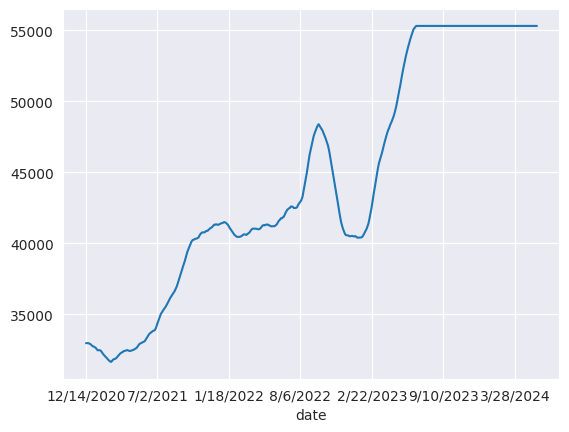

In [47]:
test_data.plot()

<Axes: xlabel='date'>

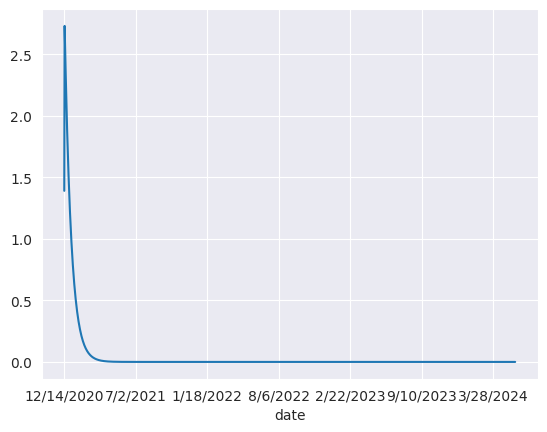

In [48]:
fc_series.plot()

<Axes: xlabel='date'>

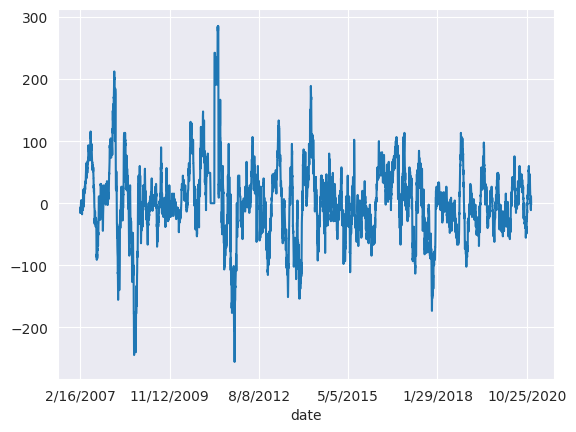

In [49]:
train_data.plot()

In [50]:
diff_data = fc_series.copy()

reverted_data = test_data.iloc[0] + diff_data.cumsum()
# Compute the cumulative sum to revert the diff transformation


<Axes: xlabel='date'>

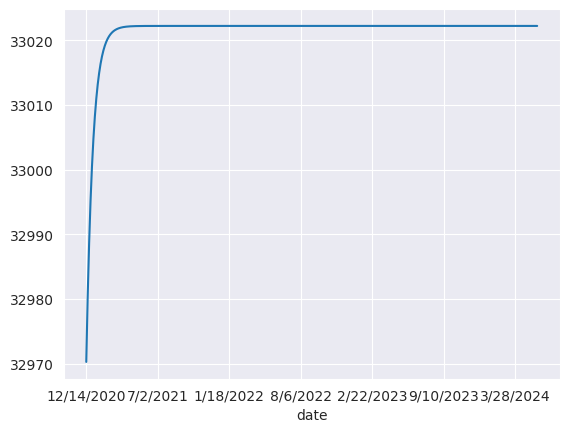

In [51]:
reverted_data.plot()

In [52]:
test_data

date
12/14/2020    32968.888889
12/15/2020    32975.555556
12/16/2020    32975.555556
12/17/2020    32975.555556
12/18/2020    32977.777778
                  ...     
5/28/2024     55300.000000
5/29/2024     55300.000000
5/30/2024     55300.000000
5/31/2024     55300.000000
6/1/2024      55300.000000
Name: price, Length: 1263, dtype: float64

<Axes: xlabel='date'>

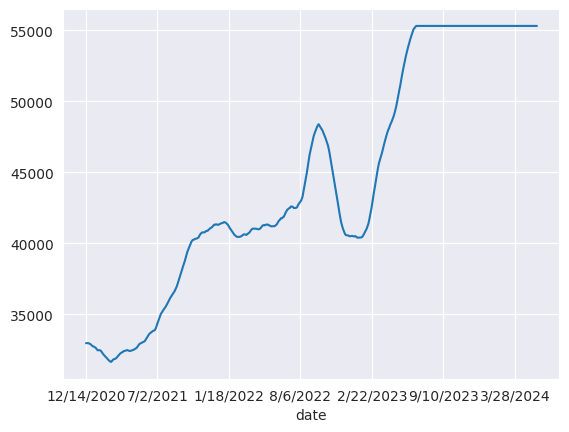

In [53]:
df1[int(len(df1)*0.8):].plot()

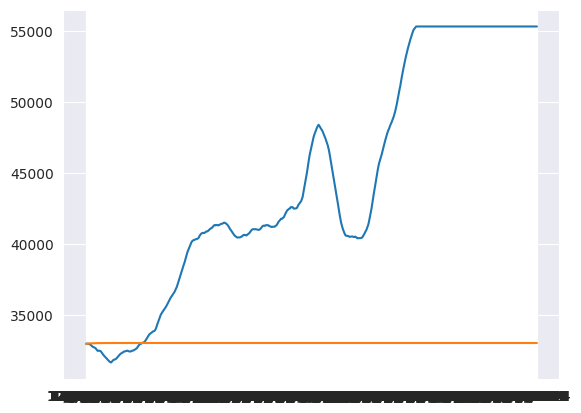

In [54]:
#plot the predictions for validation set
# plt.plot(train_data_inverse, label='Train')
plt.plot(test_data, label='Valid')
plt.plot(reverted_data, label='Prediction')
plt.show()

In [55]:
rmse = sqrt(mean_squared_error(test_data.values, reverted_data))
rmse

14072.511669371648

In [56]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

Đánh giá mô hình với RMSE và MAPE

In [57]:
forecast_accuracy(test_data.values, reverted_data.values)

{'mape': 35.26771709213725, 'rmse': 14072.511669371648}

In [59]:
import joblib
from google.colab import drive

file_name = "arima_gia_cafe.joblib"
drive.mount('/content/drive')

joblib.dump(model_arima, '/content/drive/MyDrive/model/' + file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/model/arima_gia_cafe.joblib']